In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split

In [2]:
def format_output(data):
    y1 = data.pop('Y1')
    y1 = np.array(y1)
    y2 = data.pop('Y2')
    y2 = np.array(y2)
    return y1, y2


def norm(x):
    return (x - train_stats['mean']) / train_stats['std']


def plot_diff(y_true, y_pred, title=''):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.plot([-100, 100], [-100, 100])
    plt.show()


def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)
    plt.show()

In [3]:
# Get the data from UCI dataset
URL = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx'

# Use pandas excel reader
df = pd.read_excel(URL)
df = df.sample(frac=1).reset_index(drop=True)
# .reset_index() : Reset the index of the DataFrame, and use the default one instead.
# If the DataFrame has a MultiIndex, this method can remove one or more levels.
# Return DataFrame with the new index or None if inplace=True.


# Split the data into train and test with 80 train / 20 test
train, test = train_test_split(df, test_size=0.2)
train_stats = train.describe()

# Get Y1 and Y2 as the 2 outputs and format them as np arrays
train_stats.pop('Y1')
train_stats.pop('Y2')
train_stats = train_stats.transpose()
train_Y = format_output(train)
test_Y = format_output(test)

# Normalize the training and test data
norm_train_X = norm(train)
norm_test_X = norm(test)

In [30]:
# Define model layers.
input_layer = Input(shape=(len(train .columns),))
first_dense = Dense(units='128', activation='relu')(input_layer)
second_dense = Dense(units='128', activation='relu')(first_dense)

# Y1 output will be fed directly from the second dense
y1_output = Dense(units='1', name='y1_output')(second_dense)
third_dense = Dense(units='64', activation='relu')(second_dense)

# Y2 output will come via the third dense
y2_output = Dense(units='1', name='y2_output')(third_dense)

# Define the model with the input layer and a list of output layers
model = Model(inputs=input_layer, outputs=[y1_output, y2_output])

print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 128)          1152        input_2[0][0]                    
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 128)          16512       dense_3[0][0]                    
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 64)           8256        dense_4[0][0]                    
____________________________________________________________________________________________

In [31]:
# Specify the optimizer, and compile the model with loss functions for both outputs
optimizer = tf.keras.optimizers.SGD(lr=0.001)
model.compile(optimizer=optimizer,
              loss={'y1_output': 'mse', 'y2_output': 'mse'},
              metrics={'y1_output': tf.keras.metrics.RootMeanSquaredError(),
                       'y2_output': tf.keras.metrics.RootMeanSquaredError()})

In [32]:
# Train the model for 500 epochs
history = model.fit(norm_train_X, train_Y,
                    epochs=500, batch_size=10, validation_data=(norm_test_X, test_Y))

Epoch 1/500
62/62 [==============================] - 1s 5ms/step - loss: 611.2217 - y1_output_loss: 290.9766 - y2_output_loss: 320.2451 - y1_output_root_mean_squared_error: 16.3926 - y2_output_root_mean_squared_error: 17.1494 - val_loss: 61.4005 - val_y1_output_loss: 18.6438 - val_y2_output_loss: 42.7567 - val_y1_output_root_mean_squared_error: 4.3178 - val_y2_output_root_mean_squared_error: 6.5389
Epoch 2/500
62/62 [==============================] - 0s 2ms/step - loss: 32.1759 - y1_output_loss: 12.4964 - y2_output_loss: 19.6796 - y1_output_root_mean_squared_error: 3.5285 - y2_output_root_mean_squared_error: 4.4233 - val_loss: 25.2819 - val_y1_output_loss: 10.0704 - val_y2_output_loss: 15.2115 - val_y1_output_root_mean_squared_error: 3.1734 - val_y2_output_root_mean_squared_error: 3.9002
Epoch 3/500
62/62 [==============================] - 0s 2ms/step - loss: 22.4516 - y1_output_loss: 9.4495 - y2_output_loss: 13.0021 - y1_output_root_mean_squared_error: 3.0587 - y2_output_root_mean_squ

In [33]:
# Test the model and print loss and mse for both outputs
loss, Y1_loss, Y2_loss, Y1_rmse, Y2_rmse = model.evaluate(x=norm_test_X, y=test_Y)
print("Loss = {}, Y1_loss = {}, Y1_mse = {}, Y2_loss = {}, Y2_mse = {}".format(loss, Y1_loss, Y1_rmse, Y2_loss, Y2_rmse))

5/5 [==============================] - 0s 2ms/step - loss: 1.3884 - y1_output_loss: 0.2584 - y2_output_loss: 1.1299 - y1_output_root_mean_squared_error: 0.5084 - y2_output_root_mean_squared_error: 1.0630
Loss = 1.388352394104004, Y1_loss = 0.2584258019924164, Y1_mse = 0.508355975151062, Y2_loss = 1.1299266815185547, Y2_mse = 1.062980055809021


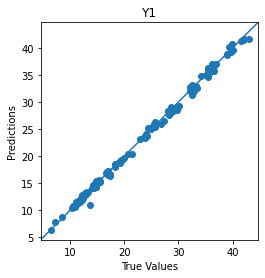

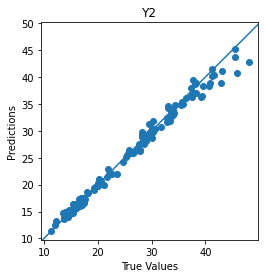

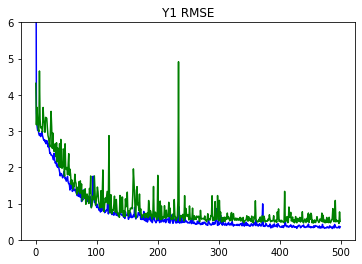

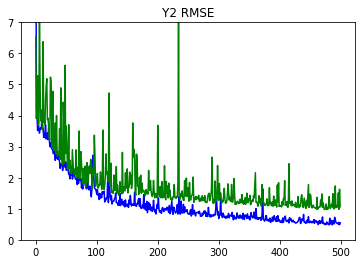

In [34]:
# Plot the loss and mse
Y_pred = model.predict(norm_test_X)
plot_diff(test_Y[0], Y_pred[0], title='Y1')
plot_diff(test_Y[1], Y_pred[1], title='Y2')
plot_metrics(metric_name='y1_output_root_mean_squared_error', title='Y1 RMSE', ylim=6)
plot_metrics(metric_name='y2_output_root_mean_squared_error', title='Y2 RMSE', ylim=7)


